In [84]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import xtrack as xt
from pathlib import Path
import pandas as pd

from zoneinfo import ZoneInfo
from datetime import timedelta, datetime
import json
from matplotlib.lines import Line2D

In [ ]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self.fields:
            for i, bpm in enumerate(self[crate]['value']['channelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self[crate]['value']['positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

In [3]:
directory = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/abwlm/SPS.USER.MD2')
paths_files_list = list(directory.glob("*.parquet"))
path_files = {}
for path in paths_files_list:
    stem = path.stem
    dt = datetime.strptime(stem, "%Y.%m.%d.%H.%M.%S.%f")
    dt = dt.replace(tzinfo=ZoneInfo("Europe/Paris"))
    path_files[dt] = path
path_files = pd.DataFrame.from_dict(path_files, orient='index', columns=['path'])
path_files.index = pd.to_datetime(path_files.index)
print(path_files.index.is_monotonic_increasing)
path_files = path_files.sort_index() #Files need to be sorted by index for correct time series handling
print(path_files.index.is_monotonic_increasing)

False
True


In [4]:
df_params = pd.read_json('../MD_data/20250616/parameters.json').T
df_params.index = pd.to_datetime(df_params.index) #convert index (string timestamp) to datetime
df_params.index = df_params.index.tz_localize("Europe/Paris") #Set to Geneva time
changes_ts = df_params.index.to_numpy()

df_fo = pd.read_json('../MD_data/20250616/full_overview.json').T
df_fo.index = pd.to_datetime(df_fo.index) #convert index (string timestamp) to datetime
df_fo.index = df_fo.index.tz_localize("Europe/Paris") #Set to Geneva time

# Making new dict with paths per timestamp
paths_per_ts = {}
dt = timedelta(seconds=1)
for ts_start, ts_end in zip(changes_ts[:-1], changes_ts[1:]):
    ll = df_fo.loc[ts_start:ts_end-dt].index.to_numpy()
    lll = path_files.loc[ts_start:ts_end-dt, "path"].to_numpy()
    
    for i in range(len(ll)):
        if len(lll) > i:
            paths_per_ts[ll[i]] = lll[i]
paths_per_ts = pd.DataFrame.from_dict(paths_per_ts, orient='index', columns=['path'])

In [48]:
class ABWLMBehavior(ak.Record):
    pass

class ABWLMCollectionBehavior(ak.Array):
    def cycle_stamp(self):
        return self['ABWLMSPS/Acquisition']['header']['cycleStamp'][0]
    
    def acq_done(self):
        return self['ABWLMSPS/Acquisition']['value']['acquisitionDone'][0]

    def bunch_intensities(self):
        return self['ABWLMSPS/Acquisition']['value']['bunchIntensities'][0][:,0]

    def bunch_lengths(self):
        return self['ABWLMSPS/Acquisition']['value']['bunchLengths'][0][:,0]

    def acq_time_from_inj(self):
        return self['ABWLMSPS/Acquisition']['value']['acqTimeFromInj'][0]
    
    def bucket_height(self):
        return self['ABWLMSPS/Acquisition']['value']['bucketHeight'][0][:,0]

ak.behavior["*", "ABWLMCollection"] = ABWLMCollectionBehavior

In [26]:
def parse_timestamp_data(ts: str) -> datetime:
    """Convert 'YYYY.MM.DD.HH.MM.SS.microseconds' into a datetime object."""
    return datetime.strptime(ts, "%Y.%m.%d.%H.%M.%S.%f")

def parse_timestamp_overview(ts: str) -> datetime:
    """Convert 'YYYY-MM-DD HH:MM:SS.microseconds' into a datetime object."""
    return datetime.strptime(ts, "%Y-%m-%d %H:%M:%S.%f")

In [19]:
with open(Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/full_overview.json')) as f:
    metadata = json.load(f)

In [49]:
data = {}
for p in paths_per_ts.path:
    ts = parse_timestamp_data(p.stem)
    data[ts] = ak.Array(ak.from_parquet(p), with_name="ABWLMCollection")

In [29]:
selected = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0}

In [53]:
from datetime import datetime
import pandas as pd

def parse_timestamp_data(ts: str) -> datetime:
    """Convert 'YYYY.MM.DD.HH.MM.SS.microseconds' into a datetime object."""
    return datetime.strptime(ts, "%Y.%m.%d.%H.%M.%S.%f")

def parse_timestamp_overview(ts: str) -> datetime:
    """Convert 'YYYY-MM-DD HH:MM:SS.microseconds' into a datetime object."""
    return datetime.strptime(ts, "%Y-%m-%d %H:%M:%S.%f")

def parse_any_timestamp(ts):
    """
    Parse a timestamp into a datetime.
    Supports:
      - int (nanoseconds since epoch)
      - overview strings (YYYY-MM-DD HH:MM:SS.microseconds)
      - data strings (YYYY.MM.DD.HH.MM.SS.microseconds)
      - already datetime
    """
    if isinstance(ts, int):  # nanoseconds since epoch
        return pd.to_datetime(ts, unit="ns").to_pydatetime()
    elif isinstance(ts, str):
        for parser in (parse_timestamp_overview, parse_timestamp_data):
            try:
                return parser(ts)
            except ValueError:
                continue
        # fallback: try without microseconds
        try:
            return datetime.strptime(ts, "%Y-%m-%d %H:%M:%S")
        except ValueError:
            raise ValueError(f"Unrecognized timestamp format: {ts}")
    elif isinstance(ts, datetime):
        return ts
    else:
        raise TypeError("Timestamp must be int, str, or datetime")


In [54]:
def match_timestamps(meta_ts, data_ts_list, tolerance=pd.Timedelta("10s")):
    """
    Find the closest data timestamp to the given metadata timestamp.
    
    meta_ts        : str|int|datetime
    data_ts_list   : list of str|int|datetime
    tolerance      : maximum allowed difference (default: 10s)
    
    Returns: matching timestamp from data_ts_list or None if no match.
    """
    meta_dt = parse_any_timestamp(meta_ts)
    data_dts = [parse_any_timestamp(ts) for ts in data_ts_list]

    diffs = [abs((dt - meta_dt).total_seconds()) for dt in data_dts]
    min_idx = int(pd.Series(diffs).idxmin())

    if diffs[min_idx] <= tolerance.total_seconds():
        return data_ts_list[min_idx]
    return None

In [55]:
match_timestamps('2025-06-16 11:52:17.9', list(data.keys()))

datetime.datetime(2025, 6, 16, 11, 52, 23, 294906)

# Case 1

Positive radial steering, no tune shift, no bump, effect of chroma

"radial_steering": "DPpos",   
"bump": 0.0,   
"chroma": 0.5,   
"tune_shift": 0.0  

In [56]:
selected = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 0.5 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPpos"}

In [68]:
chroma_05 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 0.5 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPpos"}
chroma_07 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 0.7 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPpos"}
chroma_10 = {ts: params for ts, params in metadata.items() if params["bump"] == 0.0 and params["chroma"] == 1.0 and params["tune_shift"] == 0.0 and params["radial_steering"] == "DPpos"}

In [77]:
ts_metadata = {0.5 : list(chroma_05.keys()), 0.7 : list(chroma_07.keys()), 1.0 : list(chroma_10.keys())}
data_ts = {}

for chroma in ts_metadata:
    data_ts[chroma] = []
    for ts in ts_metadata[chroma]:
        data_ts[chroma].append(match_timestamps(ts, list(data.keys())))

In [78]:
data_ts

{0.5: [datetime.datetime(2025, 6, 16, 11, 52, 23, 294906),
  datetime.datetime(2025, 6, 16, 11, 53, 5, 293496),
  datetime.datetime(2025, 6, 16, 11, 53, 47, 293845),
  datetime.datetime(2025, 6, 16, 11, 54, 29, 293319),
  datetime.datetime(2025, 6, 16, 11, 55, 11, 293344)],
 0.7: [datetime.datetime(2025, 6, 16, 15, 5, 14, 894567),
  datetime.datetime(2025, 6, 16, 15, 5, 56, 894184),
  datetime.datetime(2025, 6, 16, 15, 6, 38, 893658),
  datetime.datetime(2025, 6, 16, 15, 7, 20, 893558)],
 1.0: [datetime.datetime(2025, 6, 16, 15, 8, 44, 893677),
  datetime.datetime(2025, 6, 16, 15, 9, 26, 893911),
  datetime.datetime(2025, 6, 16, 15, 10, 8, 893057),
  datetime.datetime(2025, 6, 16, 15, 10, 50, 893883),
  datetime.datetime(2025, 6, 16, 15, 11, 32, 893842)]}

In [81]:
colours = {0.5: 'green', 0.7: 'orange', 1.0: 'red'}

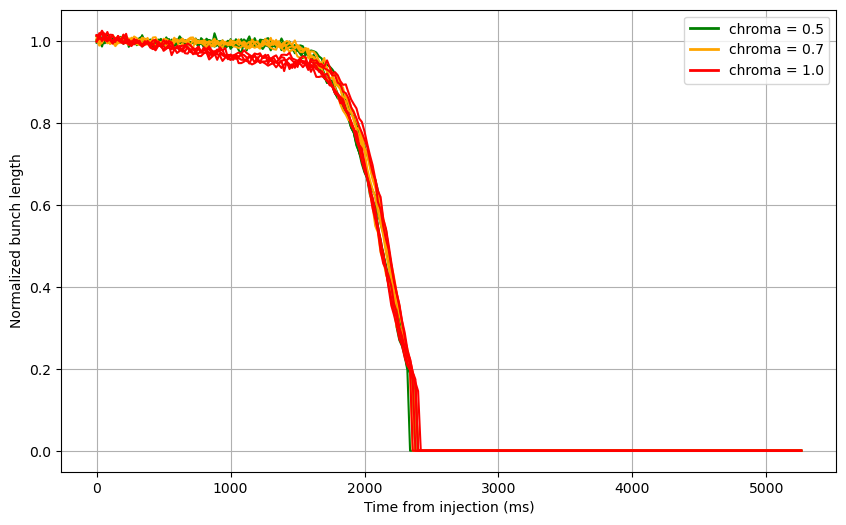

In [88]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])
        ax.plot(data[ts].acq_time_from_inj(), data[ts].bunch_intensities()/inj_val, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Time from injection (ms)")
ax.set_ylabel("Normalized bunch length")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)

In [111]:
def get_radial_steering_val(acq_time, t_start=500, t_end=2984, max_dr=32e-3):
    acq_time = np.asarray(acq_time)  # works for scalar, list, or array
    a = max_dr / (t_end - t_start)
    # result = np.where(
    #     (acq_time < t_start) | (acq_time > t_end),
    #     0.0,
    #     a * (acq_time - t_start)
    # )
    result = np.where(
        (acq_time < t_start),
        0.0,
        a * (acq_time - t_start)
    )
    # return scalar if input was scalar
    return result.item() if result.shape == () else result


In [112]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
R = line.get_length()/(2*np.pi)
gamma_tr = 1/np.sqrt(line.twiss().momentum_compaction_factor)

def get_delta_shift(dR, gamma_tr=gamma_tr, R=R):
    return dR * gamma_tr**2 / R

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


## Intensity vs delta shift

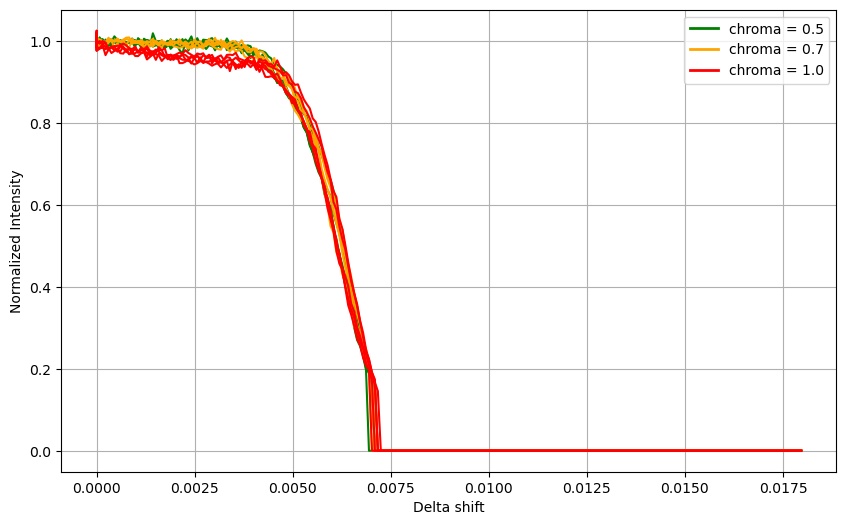

In [113]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj())
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_intensities()/inj_val_int, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Delta shift")
ax.set_ylabel("Normalized Intensity")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)

## Intensity vs bunch length

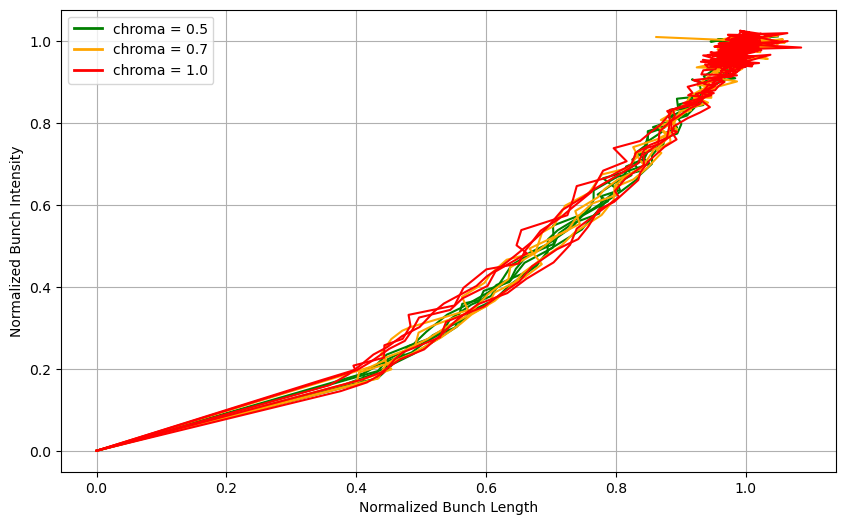

In [116]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_int = ak.mean(data[ts].bunch_intensities()[:idx_inj_time])
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj())
        delta_shift = get_delta_shift(dr)
        ax.plot(data[ts].bunch_lengths()/inj_val_bl, data[ts].bunch_intensities()/inj_val_int, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Normalized Bunch Length")
ax.set_ylabel("Normalized Bunch Intensity")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)

## Bunch length vs delta shift

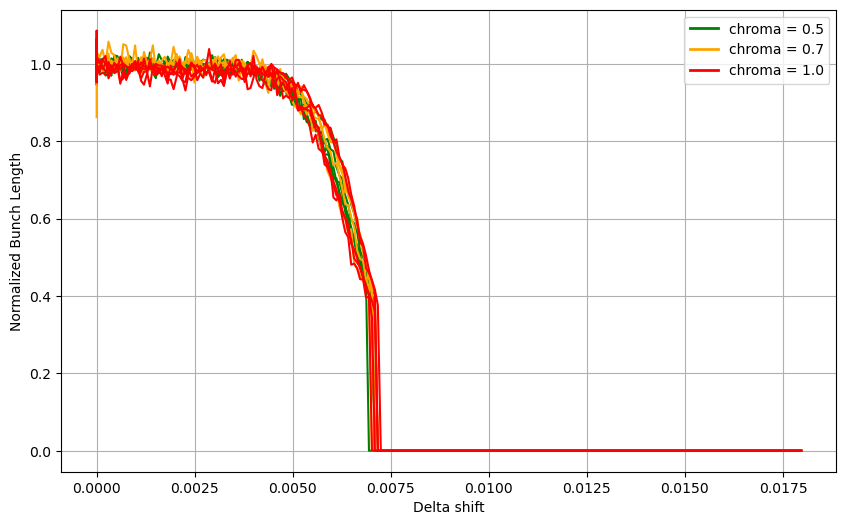

In [115]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
for chroma in data_ts:
    for ts in data_ts[chroma]:
        idx_inj_time = np.where(data[ts].acq_time_from_inj() < 500)[0][-1]
        inj_val_bl = ak.mean(data[ts].bunch_lengths()[:idx_inj_time])

        dr = get_radial_steering_val(data[ts].acq_time_from_inj())
        delta_shift = get_delta_shift(dr)
        ax.plot(delta_shift, data[ts].bunch_lengths()/inj_val_bl, color = colours[chroma], label=ts.strftime("%Y-%m-%d %H:%M:%S"))
ax.grid()
ax.set_xlabel("Delta shift")
ax.set_ylabel("Normalized Bunch Length")

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='chroma = 0.5'),
    Line2D([0], [0], color='orange', lw=2, label='chroma = 0.7'),
    Line2D([0], [0], color='red', lw=2, label='chroma = 1.0'),
]
ax.legend(handles=legend_elements)